# PCA

Testing meta base dimensionality reduction

In [1]:
import pandas as pd
import numpy as np
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.ensemble import RandomForestClassifier
import lightgbm as ltb

# Custom classes
import sys
sys.path.insert(0,'..')
from meta_learning import MetaLearner, evaluator, Model

# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

## Macros

In [ ]:
CLASS_COL = 'class'

OFFLINE_PHASE_SIZE = 10000
BASE_TRAIN_SIZE = 7000
META_TRAIN_SIZE = 0.5
R_STATE = 123

ETA = 100  # Window size used to extract meta features
STEP = 30  # Step for next meta learning iteration
KNOWN_TARGET_WINDOW_SIZE = 0  # Target is unknown

## Read data

In [2]:
f = open("../datasets/real/elec.arff", "r")
data, meta = arff.loadarff(f)

df = pd.DataFrame(data)
df['weekday'] = pd.to_numeric(df['day'])
df['class'] = df['class'].str.decode("utf-8")
df = df.drop(['date', 'period', 'day'], axis=1)

print(df.shape)
df.head()

(45312, 7)


,nswprice,nswdemand,vicprice,vicdemand,transfer,class,weekday
0,0.056443,0.439155,0.003467,0.422915,0.414912,UP,2
1,0.051699,0.415055,0.003467,0.422915,0.414912,UP,2
2,0.051489,0.385004,0.003467,0.422915,0.414912,UP,2
3,0.045485,0.314639,0.003467,0.422915,0.414912,UP,2
4,0.042482,0.251116,0.003467,0.422915,0.414912,DOWN,2


In [3]:
n = df.shape[0]
class_weight = df['class'].value_counts().apply(lambda x: x/n).to_dict()
class_weight

{'DOWN': 0.5754546257062146, 'UP': 0.4245453742937853}

In [5]:
offline_df = df.iloc[:OFFLINE_PHASE_SIZE]
online_df = df.iloc[OFFLINE_PHASE_SIZE:]
validation_df = online_df.iloc[:int(OFFLINE_PHASE_SIZE*META_TRAIN_SIZE)]

## Fase offline

In [6]:
meta_model_hyperparams = [{'num_leaves': 21, 'max_depth': depth} for depth in range(5, 11)]

In [7]:
base_model = Model(basis_model=RandomForestClassifier, hyperparameters={'max_depth': 6, 'warm_start': True, 'min_samples_split': 0.05})
meta_model = Model(basis_model=ltb.LGBMRegressor, hyperparameters=meta_model_hyperparams)

learner = MetaLearner(
    base_model=base_model,
    meta_model=meta_model,
    base_model_class_column=CLASS_COL,
    eta=ETA,
    step=STEP,
    known_target_window_size=KNOWN_TARGET_WINDOW_SIZE,
    )

learner.offline_stage(offline_df)

# Experiments

In [8]:
validation_base = learner._get_offline_metabase(validation_df)

In [9]:
def plot_results(y, predicted_y, title, idx, subplot_index=(3, 3)):
    r2 = evaluator.evaluate(y, predicted_y, 'r2')
    mse = evaluator.evaluate(y, predicted_y, 'mse')
    std = np.std(y - predicted_y)
    x = range(len(y))

    plt.subplot(*subplot_index, idx + 1)
    plt.plot(x, y, label="expected")
    plt.plot(x, predicted_y, label="predicted")
    plt.title(title)
    plt.legend()

    return {'r2': r2, 'mse': mse, 'std': std}

def offline_train(update_params):
    learner._update_params(**update_params)
    learner.meta_base = learner._get_last_performances(learner.meta_base)
    learner._train_meta_model()

    model = learner.meta_model
    metric = learner.meta_label_metric
    val_base = learner._get_last_performances(validation_base)

    X, y_true = val_base.drop(learner.performance_metrics, axis=1), val_base[metric]
    y_pred = model.predict(X)
    return y_true, y_pred

## PCA

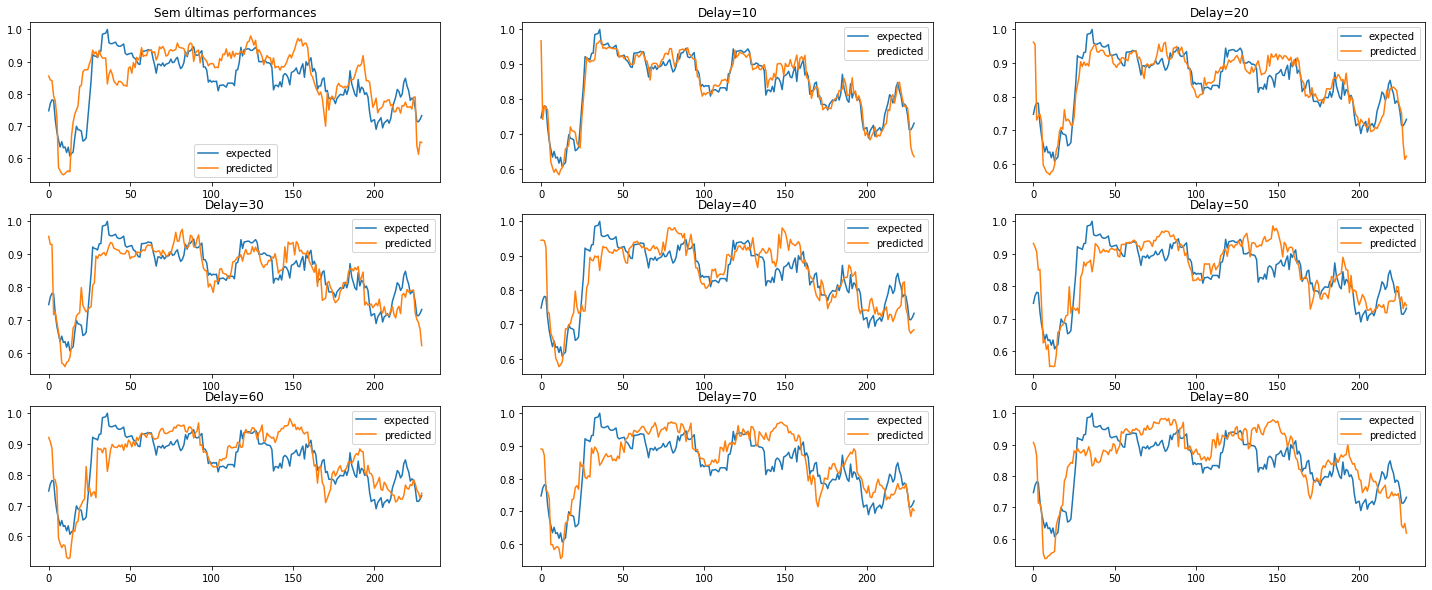

In [10]:
fig = plt.figure(figsize=(25, 10))
delays = range(1, 9)
results = []

update_params={'last_scores_delay': 0, 'last_scores_n_shifts': 0, 'meta_label_metric': 'precision' }
y_true, y_pred = offline_train(update_params)
result = plot_results(y_true, y_pred, title='Sem últimas performances', idx=0)
result['delay'] = 'N/A'
results.append(result)

for idx, delay in enumerate(delays):
    update_params={'last_scores_delay': delay, 'last_scores_n_shifts': 10, 'meta_label_metric': 'precision' }
    y_true, y_pred = offline_train(update_params)
    result = plot_results(y_true, y_pred, title=f"Delay={delay * STEP}", idx=idx+1)
    result['delay'] = delay * STEP
    results.append(result)

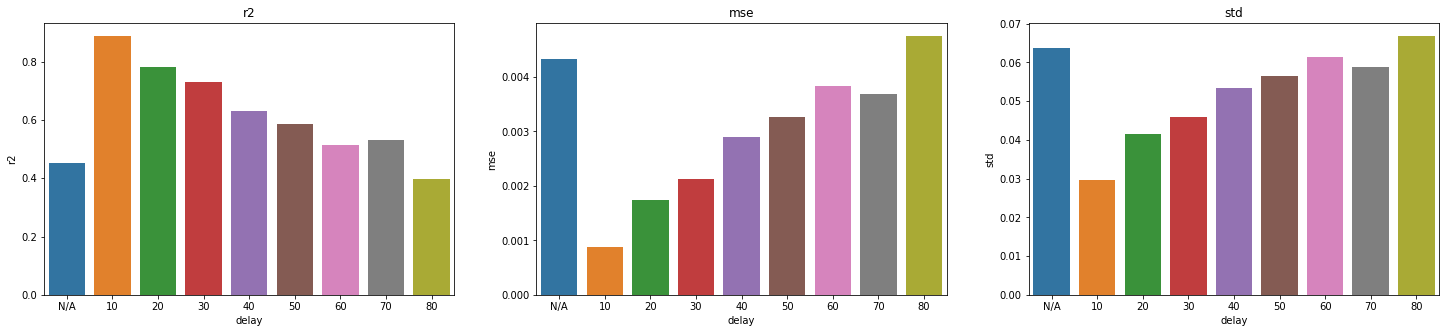

In [11]:
delay_results = pd.DataFrame(results)
fig = plt.figure(figsize=(25, 5))

for idx, col in enumerate(['r2', 'mse', 'std']):
    plt.subplot(1, 3, idx + 1)
    sns.barplot(x="delay", y=col, data=delay_results)
    plt.title(col)

In [12]:
# model = learner.meta_model.model
# lightgbm.plot_importance(model, figsize=(10, 20), max_num_features=20)